In [1]:
import time
import pooch
import pyproj
import numpy as np
import xarray as xr
import boule as bl
import verde as vd
import matplotlib.pyplot as plt

from boost_and_layouts import (
    EQLHarmonicBoost,
    block_averaged_sources,
    combine_parameters,
)


## Download Australia gravity data

In [2]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True),
)

# Load the data with xarray
data = xr.load_dataset(fname)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

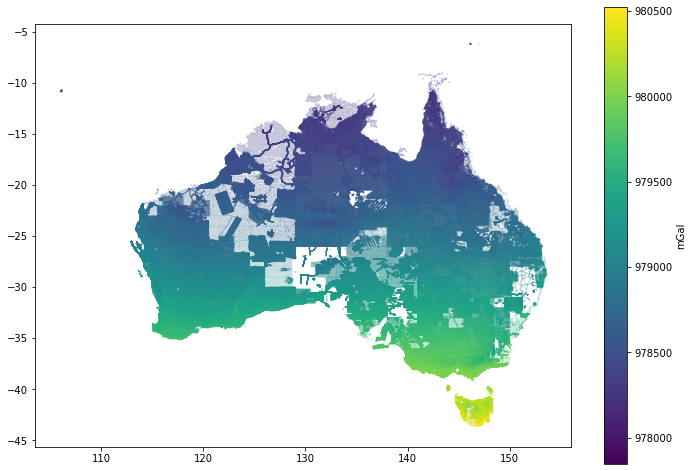

In [4]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Compute gravity disturbance

In [5]:
ell = bl.WGS84
disturbance = data.gravity - ell.normal_gravity(data.latitude, data.height)
data["disturbance"] = ("point", disturbance)

In [6]:
data

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    disturbance        (point) float64 -4.502 -3.588 -3.967 ... 7.314 11.59
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

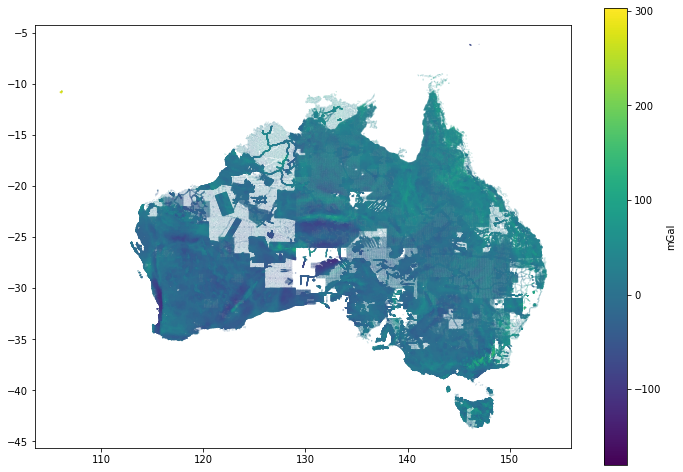

In [7]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Keep only points close to the continent

In [8]:
coordinates = (data.longitude.values, data.latitude.values, data.height.values)
disturbance = data.disturbance.values

vd.get_region(coordinates)

(105.93008499999999, 153.61476, -43.735188, -6.12522)

In [9]:
inside = vd.inside(coordinates, region=(111, 154, -44, -7))
coordinates = tuple(c[inside] for c in coordinates)
disturbance = disturbance[inside]

In [10]:
vd.get_region(coordinates)

(112.934764, 153.61476, -43.735188, -9.008531999999999)

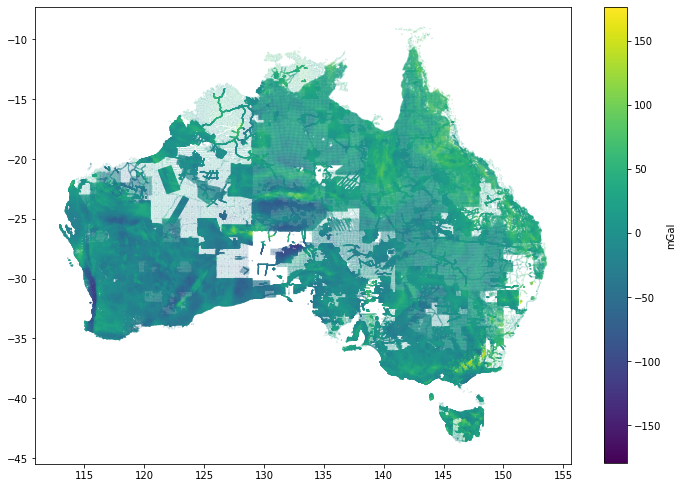

In [11]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Project coordinates

In [12]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())

easting, northing = projection(*coordinates[:2])
proj_coordinates = (easting, northing, coordinates[-1])

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


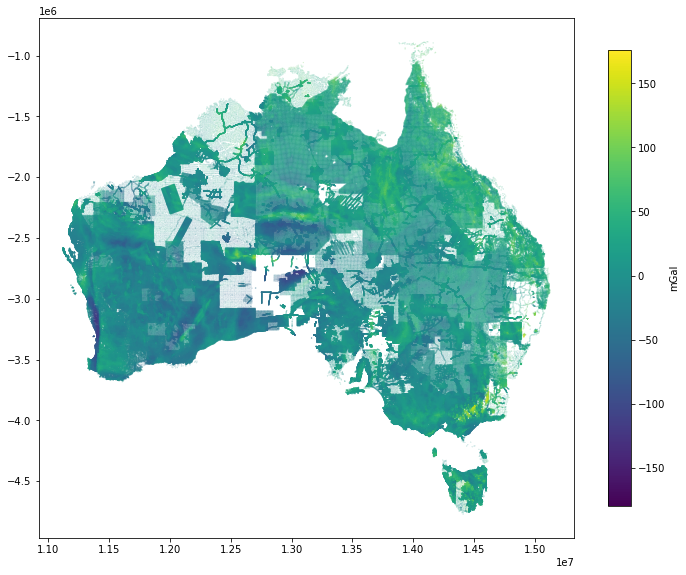

In [13]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Estimate parameters: spacing for block-averaged sources and window size for gradient boosting

Estimate the block spacing that we will use for block-averaged sources

In [14]:
# Get number of data points
n_data = proj_coordinates[0].size
print("Number of data points: {}".format(n_data))

Number of data points: 1789755


In [15]:
spacings = np.linspace(4e3, 10e3, 7)

n_data_per_sources = []
for spacing in spacings:
    sources = block_averaged_sources(
        proj_coordinates, spacing=spacing, depth_type="relative_depth", depth=0
    )
    n_data_per_sources.append(n_data / sources[0].size)

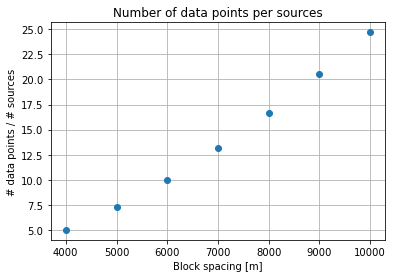

In [16]:
plt.plot(spacings, n_data_per_sources, "o")
plt.xlabel("Block spacing [m]")
plt.ylabel("# data points / # sources")
plt.title("Number of data points per sources")
plt.grid()
plt.show()

Lets choose a block spacing of 9000m so we obtain ~20 data points per source

In [17]:
spacing = 9000

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Estimate the window size for gradient boosting

In [18]:
window_sizes = np.linspace(100e3, 1000e3, 10)

# Create sources with the spacing obtained before
sources = block_averaged_sources(
    proj_coordinates, spacing=spacing, depth_type="relative_depth", depth=0
)

memory_gb = []
for window_size in window_sizes:
    eql = EQLHarmonicBoost(window_size=window_size)
    eql.points_ = sources
    source_windows, data_windows = eql._create_rolling_windows(proj_coordinates)
    # Get the size of each source and data windows
    source_sizes = np.array([w.size for w in source_windows])
    data_sizes = np.array([w.size for w in data_windows])
    # Compute the size of the Jacobian matrix for each window
    jacobian_sizes = source_sizes * data_sizes
    # Register the amount of memory to store the Jacobian matrix (double precision)
    memory_gb.append(jacobian_sizes.max() * (64 / 8) / 1024 ** 3)

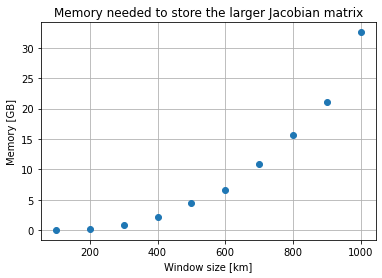

In [19]:
plt.plot(window_sizes * 1e-3, memory_gb, "o")
plt.xlabel("Window size [km]")
plt.ylabel("Memory [GB]")
plt.title("Memory needed to store the larger Jacobian matrix")
plt.grid()
plt.show()

### Conclusions:

- Choose a spacing of 9000m so we obtain ~20 data points per source
- Choose a window size of 600km so we don't exceed 10GB of RAM.

In [20]:
window_size = 600e3
spacing = 9e3

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cross-validate gridder for estimating parameters

Choose only a portion of the data to apply CV to speed up things

In [21]:
easting_0, northing_0 = 13783825.0, -3661038.0
easting_size, northing_size = 1000e3, 1000e3
smaller_region = (
    easting_0,
    easting_0 + easting_size,
    northing_0,
    northing_0 + northing_size,
)

inside = vd.inside(proj_coordinates, region=smaller_region)
proj_coords_cv = tuple(c[inside] for c in proj_coordinates)
disturbance_cv = disturbance[inside]

print(f"Number of data points for CV: {proj_coords_cv[0].size}")
print(f"Small region: {vd.get_region(proj_coords_cv)}")

Number of data points for CV: 213604
Small region: (13783825.71330877, 14783821.858323414, -3661032.8970217854, -2661039.857510804)


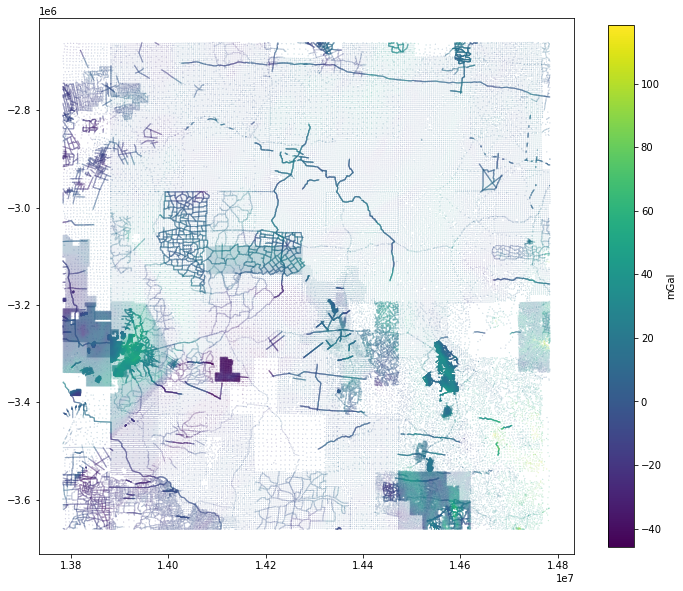

In [22]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coords_cv[:2], c=disturbance_cv, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.8)
plt.show()

Define parameters space

In [23]:
depth_type = "relative_depth"
random_state = 0
dampings = np.logspace(-2, 3, 6)
depths = [1e3, 2e3, 5e3, 10e3, 15e3]

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=spacing,
        window_size=window_size,
        random_state=random_state,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 30


Apply cross validation

In [24]:
%%time
cv = vd.BlockKFold(spacing=50e3, n_splits=3, shuffle=True, random_state=0)

scores = []
for parameters in parameter_sets:
    points = block_averaged_sources(proj_coords_cv, **parameters)
    eql = EQLHarmonicBoost(
        points=points,
        damping=parameters["damping"],
        window_size=parameters["window_size"],
        random_state=parameters["random_state"],
        line_search=True,
    )
    start = time.time()
    score = np.mean(
        vd.cross_val_score(
            eql,
            proj_coords_cv,
            disturbance_cv,
            cv=cv,
            scoring="neg_root_mean_squared_error",
        )
    )
    end = time.time()
    print("Last CV took: {:.0f}s".format(end - start))
    scores.append(score)

Last CV took: 126s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 126s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 124s
Last CV took: 125s
Last CV took: 126s
Last CV took: 125s
Last CV took: 126s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 125s
Last CV took: 124s
Last CV took: 125s
Last CV took: 125s
CPU times: user 4h 14min 34s, sys: 57min 59s, total: 5h 12min 33s
Wall time: 1h 2min 36s


In [25]:
best_score = np.max(scores)
best_parameters = parameter_sets[np.argmax(scores)]

print(best_score)
print(best_parameters)

-9.286945400855997
{'depth_type': 'relative_depth', 'depth': 15000.0, 'damping': 1000.0, 'spacing': 9000.0, 'window_size': 600000.0, 'random_state': 0}


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cross validate using the entire dataset

In [56]:
%%time
points = block_averaged_sources(proj_coordinates, **best_parameters)
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=window_size,
    random_state=best_parameters["random_state"],
    line_search=True,
)
scores = vd.cross_val_score(eql, proj_coordinates, disturbance, cv=cv, scoring="neg_root_mean_squared_error",)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(4, 10).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(18, 31).
  jacobian.shape
/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/verde/base/least_squares.py:53: UserWarning: Under-determined problem detected (ndata, nparams)=(18, 31).
  jacobian.shape


CPU times: user 3h 38min 36s, sys: 34min 47s, total: 4h 13min 24s
Wall time: 41min 13s


In [58]:
np.mean(scores)

-14.785790596913065

## Grid gravity disturbance

In [59]:
points = block_averaged_sources(proj_coordinates, **best_parameters)

In [60]:
memory_gb = proj_coordinates[0].size * points[0].size * (64 / 8) / 1024 ** 3

print("Number of data points:", proj_coordinates[0].size)
print("Number of sources:", points[0].size)
print("Memory needed to store the full Jacobian matrix: {:.2f} GB".format(memory_gb))

Number of data points: 1789755
Number of sources: 87339
Memory needed to store the full Jacobian matrix: 1164.64 GB


In [61]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
    line_search=True,
)
eql.fit(proj_coordinates, disturbance)

CPU times: user 1h 42min 44s, sys: 15min 15s, total: 1h 57min 59s
Wall time: 20min 58s


EQLHarmonicBoost(damping=1000.0,
                 points=(array([14411127.63932425, 14402561.87884782, 14412243.24296051, ...,
       14098332.11027588, 14113756.99691306, 14120484.48755517]),
                         array([-4771579.81016954, -4757594.61523449, -4758554.51837204, ...,
        -891969.58591013,  -884706.64306358,  -886852.78427801]),
                         array([-15002.224, -14880.218, -14940.713, ..., -14912.896, -14919.548,
       -14920.13 ], dtype=float32)),
                 random_state=0, window_size=600000.0)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


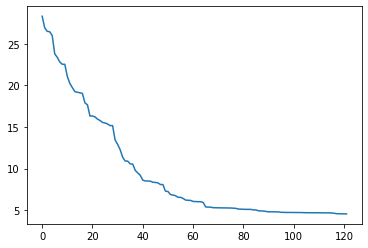

In [62]:
plt.plot(eql.errors_)
plt.show()

In [63]:
%%time
# Get region of longitude, latitude coordinates (in degrees)
region = vd.get_region(coordinates)
# Interpolate on a regular grid on geographic coordinates
grid = eql.grid(
    upward=data.height.values.max(),
    region=region,
    spacing=0.02,
    projection=projection,
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 21min 49s, sys: 91.3 ms, total: 21min 49s
Wall time: 1min 24s


In [64]:
grid

<xarray.Dataset>
Dimensions:   (easting: 2035, northing: 1737)
Coordinates:
  * easting   (easting) float64 112.9 113.0 113.0 113.0 ... 153.6 153.6 153.6
  * northing  (northing) float64 -43.74 -43.72 -43.7 ... -9.049 -9.029 -9.009
    upward    (northing, easting) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    scalars   (northing, easting) float64 0.6015 0.6007 0.5999 ... 14.73 14.71
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=1000.0,\n               ...

In [65]:
grid_masked = vd.distance_mask(
    coordinates, maxdist=80e3, grid=grid, projection=projection
)

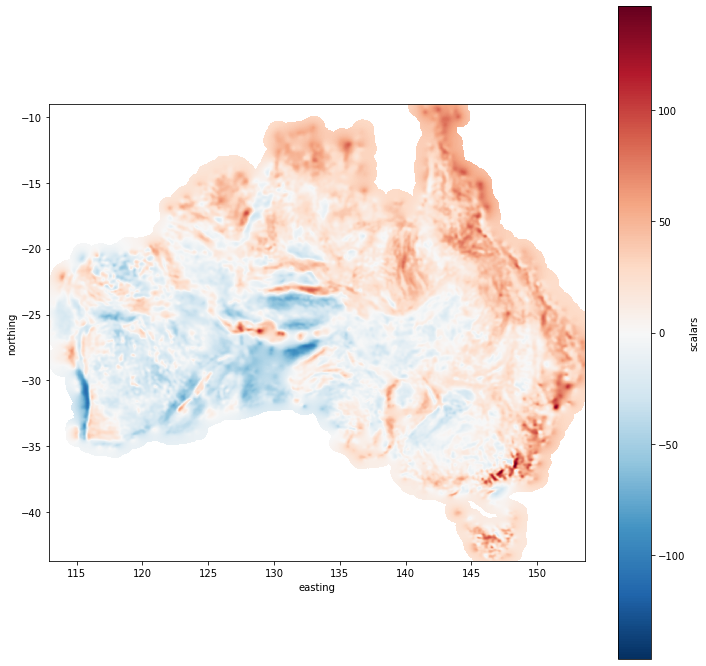

In [66]:
plt.figure(figsize=(12, 12))
grid_masked.scalars.plot()
plt.gca().set_aspect("equal")
plt.show()